<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загружаем-и-изучаем-данные" data-toc-modified-id="Загружаем-и-изучаем-данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загружаем и изучаем данные</a></span></li></ul></li><li><span><a href="#Анализ-временного-ряда" data-toc-modified-id="Анализ-временного-ряда-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ временного ряда</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Предсказание-предыдущим-значением" data-toc-modified-id="Предсказание-предыдущим-значением-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Предсказание предыдущим значением</a></span></li><li><span><a href="#Предсказание-средним-значением" data-toc-modified-id="Предсказание-средним-значением-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Предсказание средним значением</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Цель: построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка данных

### Загружаем и изучаем данные

In [1]:
import pandas as pd

import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings

In [2]:
try:
    data = pd.read_csv('taxi.csv')
except:
    print('no data')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


 Столбец `datetime` имеет тип object, переведем в datatime и сделаем его индексом датафрейма.

In [4]:
data['datetime'] = data['datetime'].astype('datetime64')
data = data.set_index('datetime')

Проверим хронологичность порядка даты и времени

In [5]:
data.index.is_monotonic

True

## Анализ временного ряда

Постоим график времянного ряда:

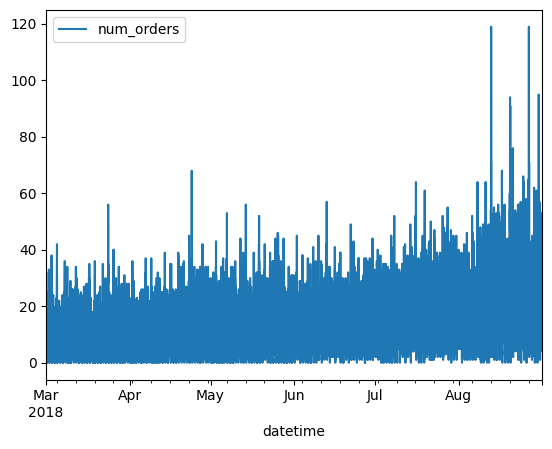

In [6]:
data.plot();

Выполним ресемплирование по одному часу

In [7]:
data = data.resample('1H').sum()

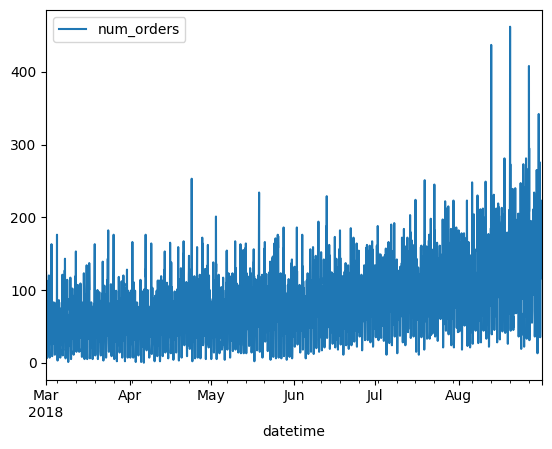

In [8]:
data.plot();

Посмотрим на тренды и сезонность:

In [9]:
decomposed = seasonal_decompose(data) 

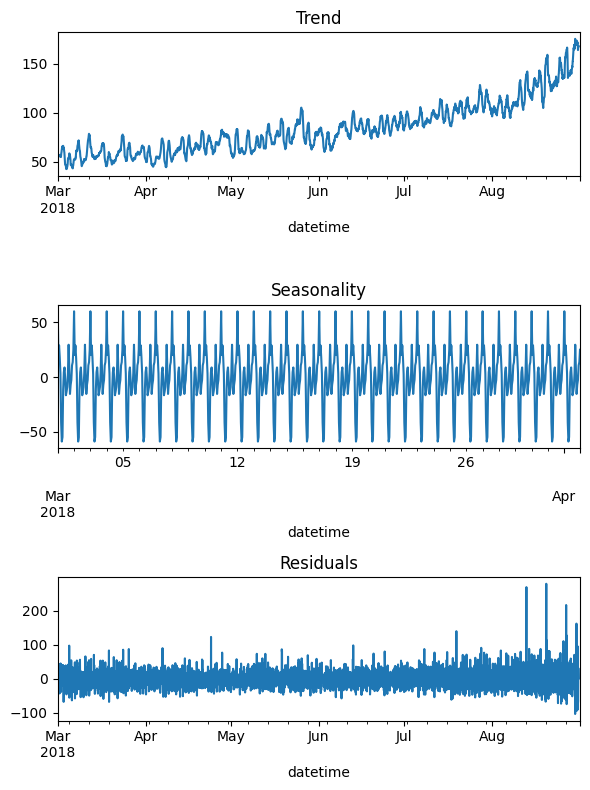

In [10]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видно, что есть восходящий тренд.
А таксже сезонность.

## Обучение

Создадим признаки:

In [11]:
warnings.filterwarnings(action="ignore")

def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['year'] = data.index.year
    data_new['month'] = data.index.month
    data_new['day'] = data.index.day
    data_new['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data_new['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new   

data_new = make_features(data, 100, 1)
data_new.head()

# включение всех предупреждений
warnings.resetwarnings()

Разбиваем данные на обучающую и валидационную, тестовую выборки в соотношении 80:10:10

In [12]:
data_new = data_new.dropna()

features = data_new.drop('num_orders', axis=1)
target= data_new['num_orders']


features_train, features_valid, target_train, target_valid  = train_test_split\
(features, target, shuffle=False, test_size=0.2)

features_valid, features_test, target_valid, target_test  = train_test_split\
(features_valid, target_valid, shuffle=False, test_size=0.5)  

print('Размер тренировочной выборки:', features_train.shape[0]/features.shape[0]*100, '%')
print('Размер валидационной выборки:', features_valid.shape[0]/features.shape[0]*100, '%' )
print('Размер тестовой выборки:', features_test.shape[0]/features.shape[0]*100, '%')

Размер тренировочной выборки: 79.9814643188137 %
Размер валидационной выборки: 10.009267840593141 %
Размер тестовой выборки: 10.009267840593141 %


### Линейная регрессия

In [13]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

result = mean_squared_error(target_valid, predictions_valid)**0.5
print("RMSE LinearRegression на валидационной выборке:", result)

RMSE LinearRegression на валидационной выборке: 30.220724953556083


In [14]:
parameters = {'fit_intercept':[True,False],'copy_X':[True, False]}

In [15]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(model, cv=tscv, param_grid=parameters,scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_

CPU times: total: 297 ms
Wall time: 1.39 s


{'copy_X': True, 'fit_intercept': False}

In [16]:
%%time
model = LinearRegression(copy_X= True, fit_intercept= False)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

result = mean_squared_error(target_valid, predictions_valid)**0.5
print("RMSE LinearRegression на валидационной выборке:", result)

RMSE LinearRegression на валидационной выборке: 30.21827785951494
CPU times: total: 15.6 ms
Wall time: 76.1 ms


### CatBoost

In [17]:
%%time
model = CatBoostRegressor(loss_function='RMSE', iterations=1000)

model.fit(features_train, target_train, verbose=500)

Learning rate set to 0.049796
0:	learn: 34.8414103	total: 181ms	remaining: 3m 1s
500:	learn: 12.9682786	total: 6.04s	remaining: 6.01s
999:	learn: 8.3259880	total: 15.4s	remaining: 0us
CPU times: total: 14.7 s
Wall time: 15.9 s


In [18]:
%%time
predictions_valid = model.predict(features_valid)

CPU times: total: 0 ns
Wall time: 21 ms


In [19]:
result = mean_squared_error(target_valid, predictions_valid)**0.5# посчитайте значение метрики RMSE на валидационной выборке
print("RMSE CatBoost на валидационной выборке:", result)

RMSE CatBoost на валидационной выборке: 30.618425587393805


In [20]:
param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'depth': [3, 5, 7]
}

In [21]:
%%time
grid = GridSearchCV(model,cv=tscv, param_grid=param_grid,scoring='neg_mean_squared_error')
grid.fit(features_train, target_train, verbose=0)
grid.best_params_

CPU times: total: 3min 44s
Wall time: 3min 50s


{'depth': 7, 'iterations': 200, 'learning_rate': 0.1}

Лучшие параметры модели для CatBoost:
{'depth': 7, 'iterations': 200, 'learning_rate': 0.1}

In [22]:
%%time
model =CatBoostRegressor(loss_function='RMSE',iterations=200, depth = 7,learning_rate=0.1)

model.fit(features_train, target_train, verbose=100)

0:	learn: 34.0047365	total: 36.5ms	remaining: 7.27s
100:	learn: 16.1029032	total: 3.74s	remaining: 3.67s
199:	learn: 12.5634087	total: 7.13s	remaining: 0us
CPU times: total: 11.2 s
Wall time: 7.29 s


In [23]:
%%time
predictions_valid = model.predict(features_valid)

CPU times: total: 0 ns
Wall time: 11 ms


In [24]:
result = mean_squared_error(target_valid, predictions_valid)**0.5# посчитайте значение метрики RMSE на валидационной выборке
print("RMSE CatBoost на валидационной выборке:", result)

RMSE CatBoost на валидационной выборке: 30.645242895807037


### LightGBM

In [25]:
%%time
model = LGBMRegressor(n_estimators=100)
model.fit(features_train, target_train, verbose=50)

C:\Users\Ксения\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


CPU times: total: 5.12 s
Wall time: 921 ms


LGBMRegressor()

In [26]:
%%time
predictions_valid = model.predict(features_valid)

CPU times: total: 31.2 ms
Wall time: 14.5 ms


In [27]:
%%time
predictions_valid = model.predict(features_valid)

CPU times: total: 46.9 ms
Wall time: 11 ms


In [28]:
result = mean_squared_error(target_valid, predictions_valid)**0.5# посчитайте значение метрики RMSE на валидационной выборке
print("RMSE LightGBM на валидационной выборке:", result)

RMSE LightGBM на валидационной выборке: 30.612705974545925


### Случайный лес

In [29]:
parameters ={'n_estimators':range(1,5), 'max_depth':range(1,10), 'min_samples_split':range(2,5)} 
model =  RandomForestRegressor()
grid = GridSearchCV(model,cv=tscv, param_grid=parameters, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 4}

In [30]:
%%time
model =  RandomForestRegressor(max_depth= 5, min_samples_split=4, n_estimators= 4)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = mean_squared_error(target_valid, predictions_valid)**0.5# посчитайте значение метрики RMSE на валидационной выборке
print("RMSE RandomForest на валидационной выборке:", result)

RMSE RandomForest на валидационной выборке: 34.61607654811733
CPU times: total: 391 ms
Wall time: 429 ms


### Предсказание предыдущим значением

In [31]:
pred_previous = target_valid.shift(fill_value=target_train.iloc[-1]) # < напишите код здесь >
print("RMSE:",mean_squared_error(pred_previous, target_valid)**0.5)

RMSE: 47.69960497545881


### Предсказание средним значением

In [32]:
pred_mean = np.ones(target_valid.shape)*target_train.mean()

print("RMSE:", mean_squared_error(pred_mean, target_valid)**0.5)# < напишите код здесь >)

RMSE: 58.660999658066665


### Вывод 

In [33]:
df = pd.DataFrame({'Model':['LinearRegression', 'CatBoost','LightGBM','RandomForestRegressor',
                            'Предсказание предыдущим значением', 'Предсказание средним значением'],
                   'rmse':[30.22,30.66,30.61,
                          35.46, 47.70, 58.66]})
df

,Model,rmse
0,LinearRegression,30.22
1,CatBoost,30.66
2,LightGBM,30.61
3,RandomForestRegressor,35.46
4,Предсказание предыдущим значением,47.70
5,Предсказание средним значением,58.66


Лучше всего показали себя CatBoost и LightGBM и LinearRegression, у которых почти одинаковый RMSE. Выберем LinearRegression, так как она быстрее остальных.

## Тестирование

In [34]:
%%time
model = LinearRegression(copy_X= True, fit_intercept= False)

model.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]))
predictions_test = model.predict(features_test)

result = mean_squared_error(target_test, predictions_test)**0.5
print("RMSE LinearRegression на тестовой выборке:", result)

RMSE LinearRegression на тестовой выборке: 41.78790624125231
CPU times: total: 31.2 ms
Wall time: 77.5 ms


LinearRegression на тестовой выборке показала результат хуже, чем на валидационной. Попробуем CatBoost.

In [35]:
%%time
model =CatBoostRegressor(loss_function='RMSE',iterations=200, depth = 7,learning_rate=0.1)

model.fit(pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid]),verbose = 100)
predictions_test = model.predict(features_test)

result = mean_squared_error(target_test, predictions_test)**0.5
print("RMSE LinearRegression на тестовой выборке:", result)

0:	learn: 36.8548906	total: 28.3ms	remaining: 5.63s
100:	learn: 17.7110652	total: 3.28s	remaining: 3.21s
199:	learn: 13.6519968	total: 6.5s	remaining: 0us
RMSE LinearRegression на тестовой выборке: 38.92859735687674
CPU times: total: 6.78 s
Wall time: 6.67 s


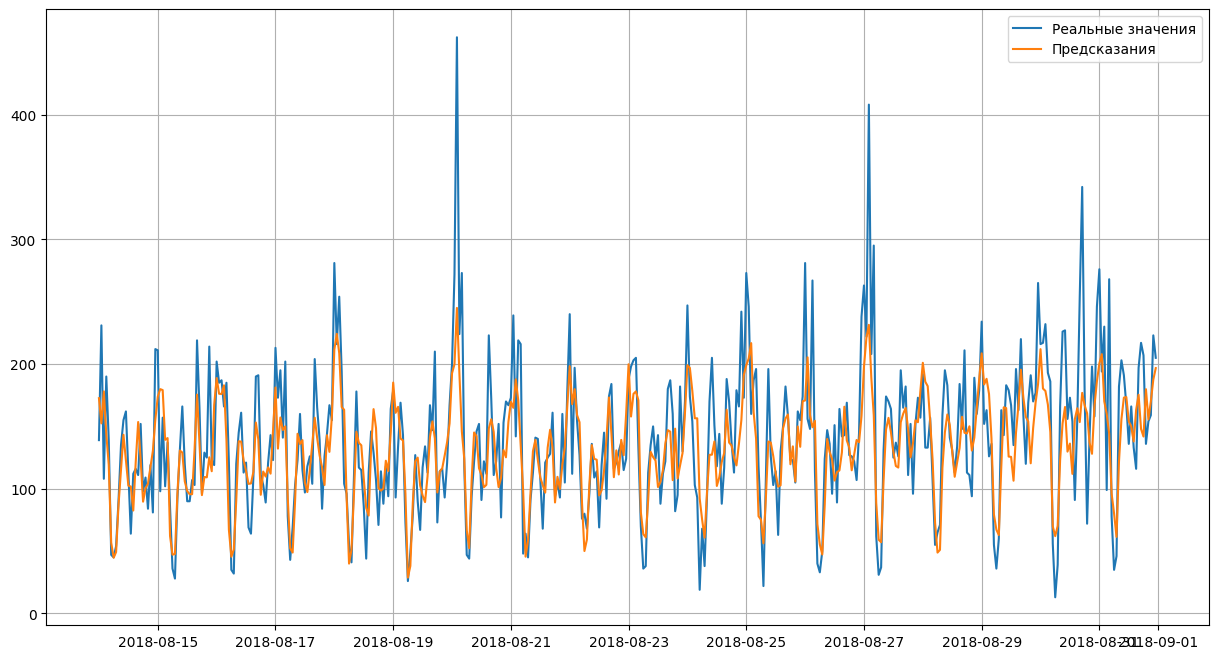

In [36]:
plt.figure(figsize=(15,8))

ax = plt.plot(target_test,  label = 'Реальные значения')
ax = plt.plot(pd.DataFrame(predictions_test, index = target_test.index), label = 'Предсказания')
plt.grid(True)
plt.legend()
plt.show()

Вывод:
- Проанализирован ряд моделей машинного обучения для предсказания времянного ряда.
- Подобраны гиперпараметры для различных моделей.
- Лучше всего показали себя CatBoost и LightGBM и LinearRegression, у которых почти одинаковый RMSE.
- RMSE LinearRegression на тестовой выборке: 38.93, в сравнении предсказание средним дает 58.66.
- На тестовой выборке CatBoost показал результат лучше RMSE 38.93.
- По графику видно, что предсказания хорошо совпадают в поведении, но есть отличия при больших значениях реальной величины.